<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "OPC"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/OPC/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


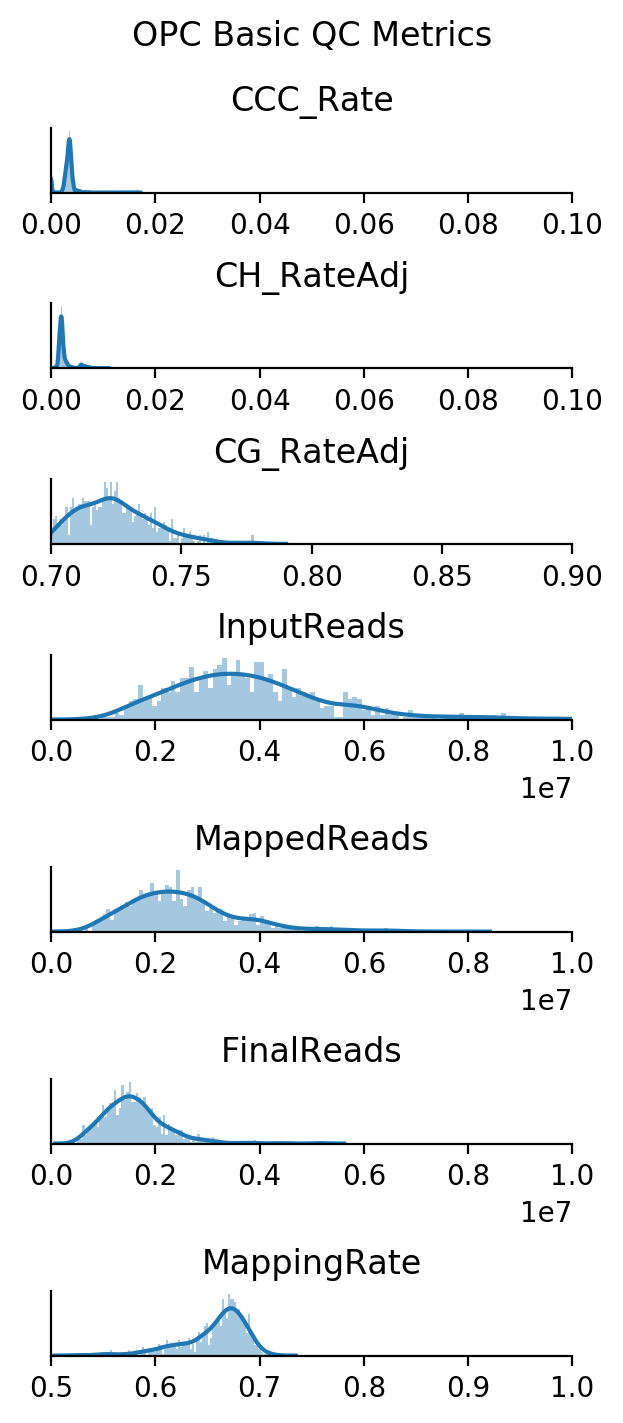

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

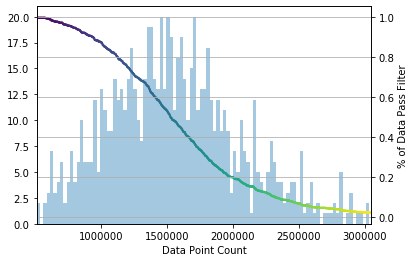

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 777/777 (100.0%)
CG_RateAdj passed 777/777 (100.0%)
CH_RateAdj passed 777/777 (100.0%)
FinalReads passed 777/777 (100.0%)
MappingRate passed 777/777 (100.0%)
Overall passed 777/777 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 6
171207 6
171212 3
171213 2
171214 2
171219 7
180104 1
180109 6
180110 10
180111 7
180119 16
180122 1
180123 6
180129 1
180130 3
180205 7
180206 9
180208 10
180212 10
180213 11
180220 8
180222 11
180226 3
180227 5
180305 6
180306 6
180312 7
180313 4
180319 1
180320 6
180326 5
180329 5
180402 8
180403 6
180405 4
180409 5
180410 4
180412 16
180416 11
180417 11
180419 8
180423 5
180424 5
180426 9
180430 10
180501 11
180514 3
180529 7
180806 3
180911 7
180917 1
180925 6
181002 9
181008 14
181009 23
181015 18
181016 12
181022 12
181023 13
181204 16
181206 32
181210 10
181218 9
181220 18
190108 4
190117 22
190122 17
190124 9
190131 17
190205 29
190207 15
190212 22
190214 28
190219 19
190305 20
190307 17
190625 4
190627 9
190711 17
190716 11


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 85 22.1%
ad002 95 24.7%
ad004 101 26.3%
ad006 92 24.0%
ad007 99 25.8%
ad008 100 26.0%
ad010 92 24.0%
ad012 113 29.4%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_1624,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003430,0.710989,0.709994,0.005504,0.002080,1858417.0,4934114,3177260.0,10E,...,-23.746927,6.987501,-35.120039,15.699155,OPC,-10.960776,-8.300772,-19.044550,16.288775,True
10E_M_1629,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003814,0.735233,0.734219,0.006040,0.002235,1852393.0,4862992,3172730.0,10E,...,-23.009550,6.507482,-35.305876,17.329749,OPC,-9.097280,-9.459278,-14.823041,8.616866,True
10E_M_1718,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003354,0.699693,0.698682,0.004884,0.001535,2308283.0,7055344,4569866.0,10E,...,-23.882900,6.609244,-36.224945,15.511577,OPC,-10.515723,-8.705353,-17.359329,13.304150,True
10E_M_1719,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003350,0.720687,0.719748,0.005132,0.001788,2286720.0,6900276,4460943.0,10E,...,-23.673712,6.505593,-36.091876,15.945464,OPC,-10.415070,-8.930613,-17.224712,13.472323,True
10E_M_173,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004004,0.725810,0.724708,0.006718,0.002725,1578639.0,4167628,2789339.0,10E,...,-23.136499,6.536149,-35.630922,17.106356,OPC,-9.151715,-9.381701,-15.623425,8.719998,True
10E_M_1815,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003866,0.703307,0.702156,0.005937,0.002080,1693028.0,4671402,2957385.0,10E,...,-24.226076,6.831336,-35.882482,15.096539,OPC,-10.644178,-8.262806,-19.587192,15.088292,True
10E_M_2265,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003448,0.721338,0.720373,0.005447,0.002006,1373699.0,3419686,2216591.0,10E,...,-24.118984,6.792854,-35.865713,15.238286,OPC,-9.654904,-8.790643,-17.257033,10.689855,True
10E_M_2271,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003561,0.726747,0.725770,0.005504,0.001950,1748475.0,4476050,2935350.0,10E,...,-24.363302,6.918023,-35.694948,14.470806,OPC,-10.922871,-7.643590,-21.893975,15.703857,True
10E_M_2552,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003588,0.724373,0.723380,0.005606,0.002025,2102226.0,5908978,3890321.0,10E,...,-23.297926,6.435475,-35.925974,16.729440,OPC,-10.184212,-9.351805,-15.835127,13.118076,True
